<h1><b>Ethereum Trading Data Analysis and Fraud Prediction</b></h1>

In [ ]:
pip install imbalanced-learn

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, PowerTransformer, StandardScaler
import xgboost as xgb
from pandas.core.dtypes.common import classes
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix

<h2><b>Data Analysis</b></h2>

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/transaction_dataset.csv') #loading dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Index                                                 9841 non-null   int64  
 1   Address                                               9841 non-null   object 
 2   FLAG                                                  9841 non-null   int64  
 3   Avg min between sent tnx                              9841 non-null   float64
 4   Avg min between received tnx                          9841 non-null   float64
 5   Time Diff between first and last (Mins)               9841 non-null   float64
 6   Sent tnx                                              9841 non-null   int64  
 7   Received Tnx                                          9841 non-null   int64  
 8   Number of Created Contracts                           9841

In [ ]:
#removing non essential features
non_essential_features = ['Index', 'Address']
data = data.drop(non_essential_features,axis=1)

In [ ]:
#Checking for Variance
data.var()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062298e+05
max value received                                      1.692294e+08
avg val received                                        8.323238e+06
min val sent                                            1.921264e+04
max val sent                                            4.394646e+07
avg val sent                      

In [ ]:
#Removing features with zero variance

zero_var_features = [' ERC20 avg time between sent tnx', ' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx', ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract']
data = data.drop(zero_var_features,axis=1)

In [ ]:
#Categorical Features Analysis

invalid_entries_sent_token = len(data[(data[' ERC20 most sent token type'] == 'None') | (data[' ERC20 most sent token type'] == '0')])
invalid_entries_rec_token = len(data[(data[' ERC20_most_rec_token_type'] == 'None') | (data[' ERC20_most_rec_token_type'] == '0')])
null_counts_sent_token = data[' ERC20 most sent token type'].isnull().sum()
null_counts_rec_token = data[' ERC20_most_rec_token_type'].isnull().sum()

print('Null Entries or Entries containing invalid value (0 or None) for ERC20 most sent token type:', invalid_entries_sent_token + null_counts_sent_token)
print('Null Entries or Entries containing invalid value (0 or None) for ERC20 most_rec_token_type:', invalid_entries_rec_token + null_counts_rec_token)

Null Entries or Entries containing invalid value (0 or None) for ERC20 most sent token type: 7096
Null Entries or Entries containing invalid value (0 or None) for ERC20 most_rec_token_type: 5270


In [ ]:
#Since both the categorical features contains significant amount of missing and invalid data, it would be wise to drop the columns

categorical_features = [' ERC20 most sent token type', ' ERC20_most_rec_token_type']
data = data.drop(categorical_features,axis=1)

# <h2><b>Data Segmentation on Basis of Target<b><h2>

In [ ]:
#segmenting data

fraud_records = data[data['FLAG'] == 1]
non_fraud_records = data[data['FLAG'] == 0]

# <h2><b>Handling Missing Values Using Segments<b><h2>

In [ ]:
#checking for null values in Fraud Transactions

fraud_records.isnull().sum()

FLAG                                                      0
Avg min between sent tnx                                  0
Avg min between received tnx                              0
Time Diff between first and last (Mins)                   0
Sent tnx                                                  0
Received Tnx                                              0
Number of Created Contracts                               0
Unique Received From Addresses                            0
Unique Sent To Addresses                                  0
min value received                                        0
max value received                                        0
avg val received                                          0
min val sent                                              0
max val sent                                              0
avg val sent                                              0
min value sent to contract                                0
max val sent to contract                

In [ ]:
non_fraud_records.isnull().sum()

FLAG                                                    0
Avg min between sent tnx                                0
Avg min between received tnx                            0
Time Diff between first and last (Mins)                 0
Sent tnx                                                0
Received Tnx                                            0
Number of Created Contracts                             0
Unique Received From Addresses                          0
Unique Sent To Addresses                                0
min value received                                      0
max value received                                      0
avg val received                                        0
min val sent                                            0
max val sent                                            0
avg val sent                                            0
min value sent to contract                              0
max val sent to contract                                0
avg value sent

In [ ]:
#Imputing Missing Values in Fraud Transactions

imputer = SimpleImputer(strategy='median')
imputed_fraud_data = pd.DataFrame(imputer.fit_transform(fraud_records))
imputed_fraud_data.columns = fraud_records.columns

# <h2><b>Aggregating Data after Imputation<b><h2>

In [ ]:
#Aggregating Data Segments After Imputing Missing Values

data = non_fraud_records.append(imputed_fraud_data)
data = data.sample(frac=1) #Shuffling data

# <h2><b>Visualisations and Feature Engineering<b><h2>

In [ ]:
flag_counts = data['FLAG'].value_counts()

In [ ]:
y = data['FLAG']
data = data.drop('FLAG',axis=1)

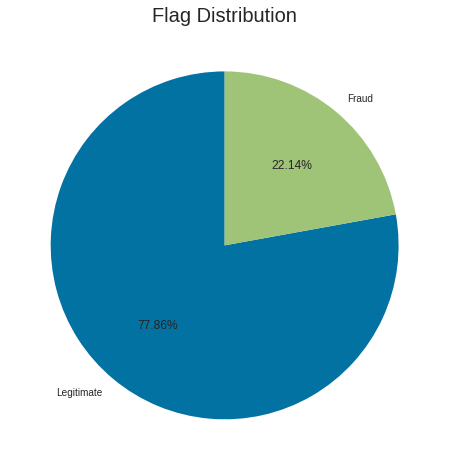

In [ ]:
plt.figure(figsize = (8,8))
plt.pie(flag_counts,labels = ['Legitimate','Fraud'], startangle = 90, autopct = '%1.2f%%')
plt.title('Flag Distribution',fontsize = 20)
plt.show()

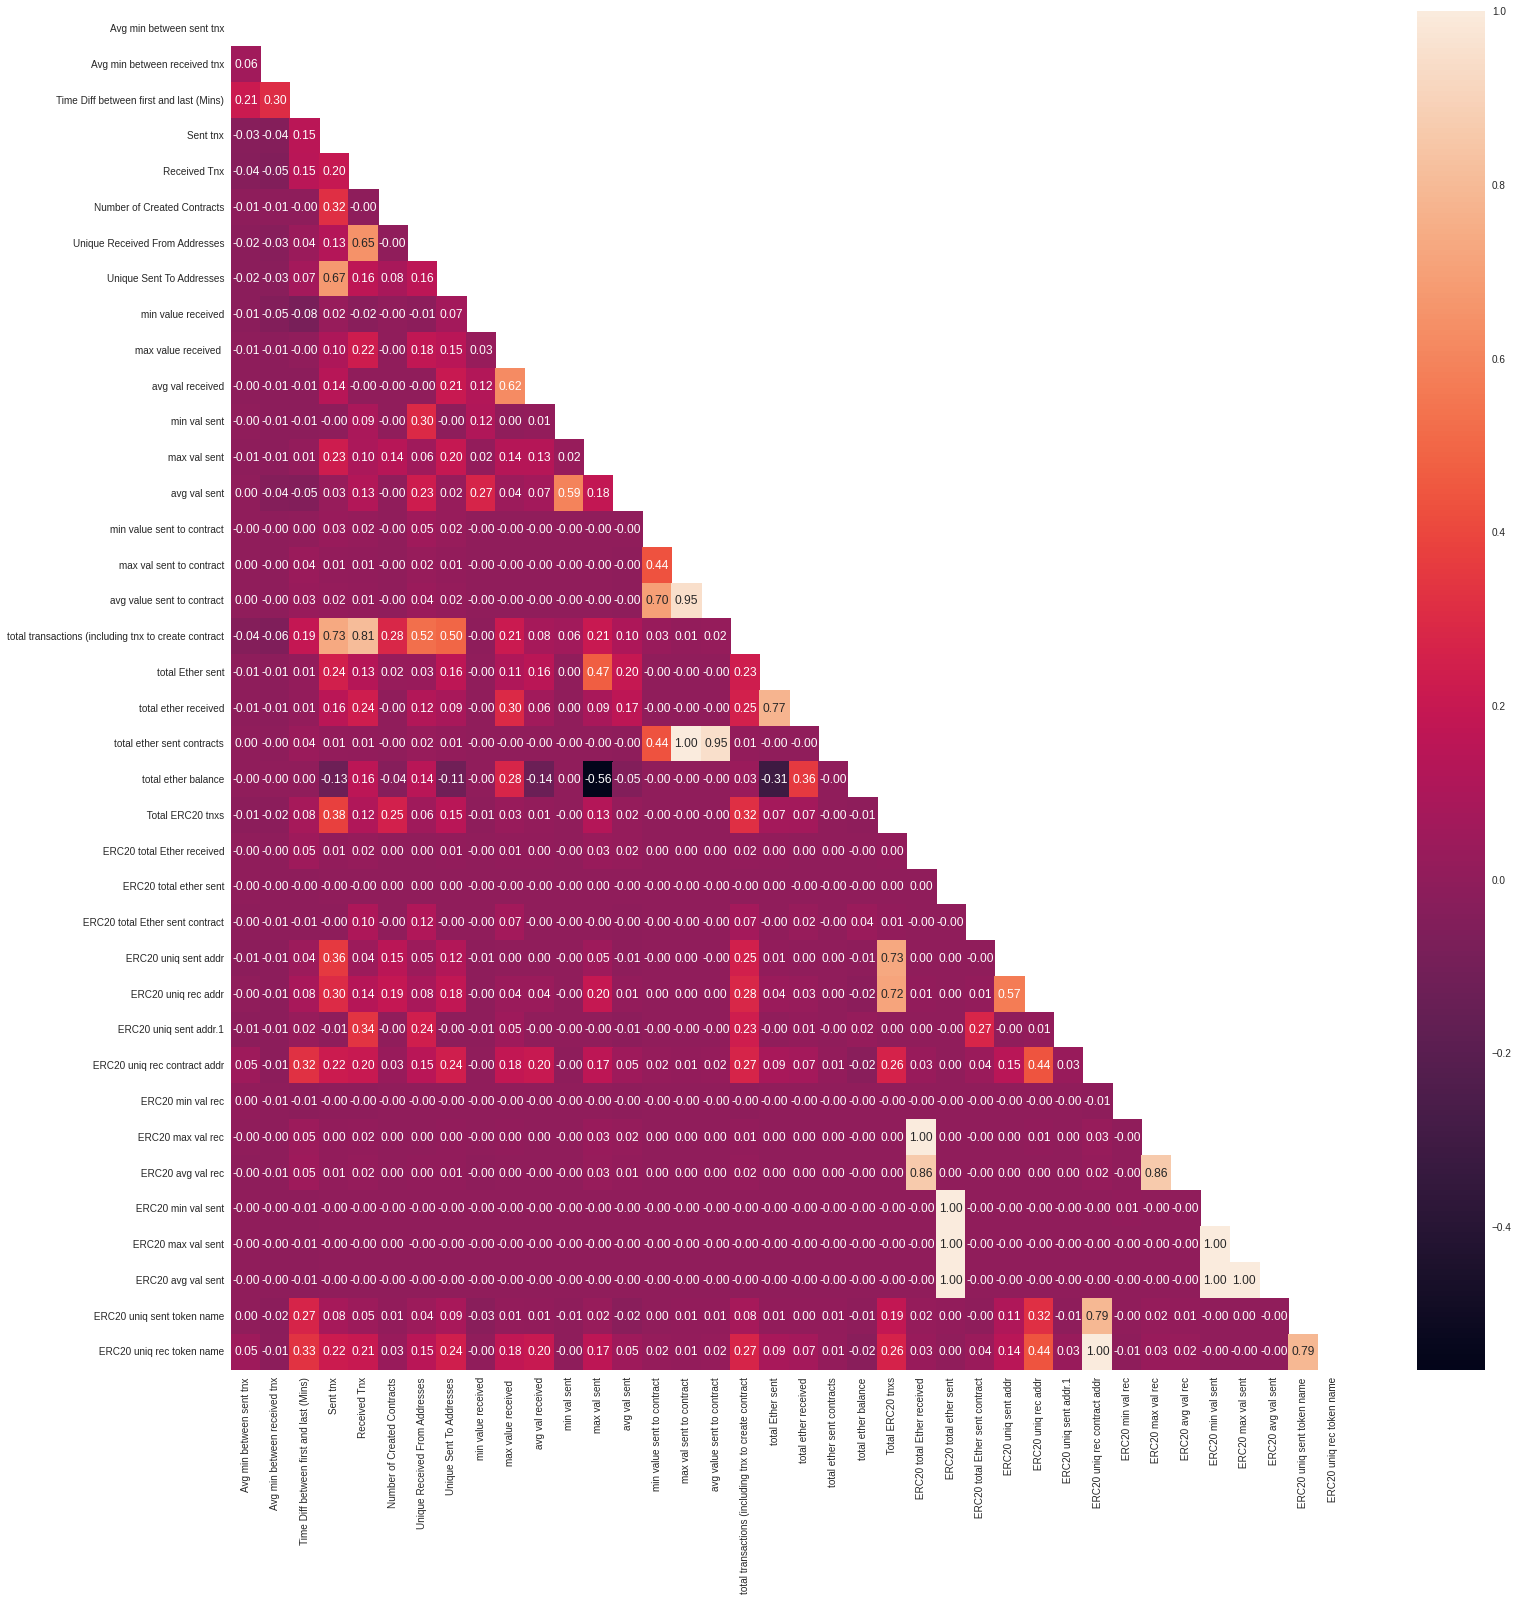

In [ ]:
corr = data.corr()
matrix = np.triu(corr)
plt.figure(figsize=(25,25))
sns.heatmap(corr,annot=True,fmt='1.2f',mask=matrix)
plt.show()

<Figure size 576x396 with 0 Axes>

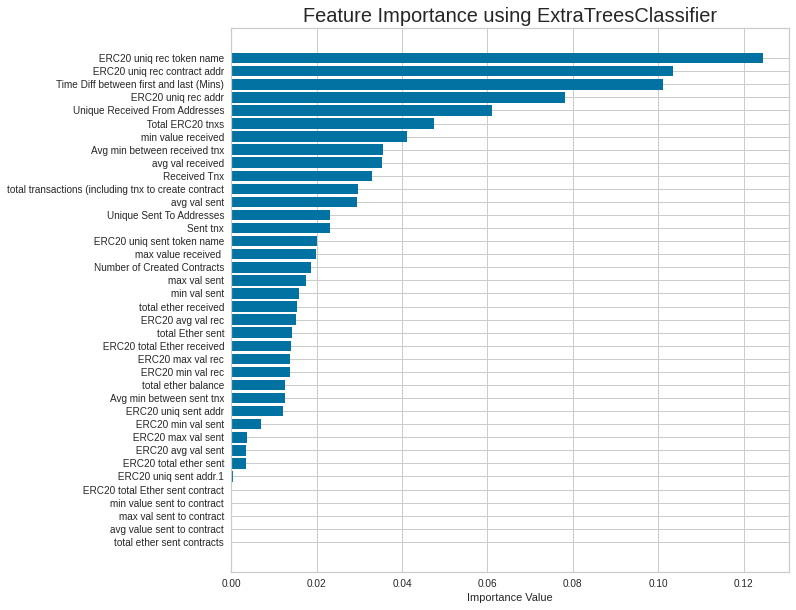

In [ ]:
model = ExtraTreesClassifier(criterion='entropy')
model.fit(data,y)
importance = model.feature_importances_
imp_dict = dict(zip(data.columns,importance))
imp_dict = dict(sorted(imp_dict.items(),key=lambda item: item[1],reverse=True))
plt.figure()
fig, ax = plt.subplots(figsize=(10,10))
y_pos = np.arange(len(data.columns))
ax.barh(y_pos,list(imp_dict.values()))
ax.set_yticks(y_pos)
ax.set_yticklabels(imp_dict.keys())
ax.invert_yaxis()
ax.set_xlabel('Importance Value')
ax.set_title('Feature Importance using ExtraTreesClassifier',fontsize = 20)
plt.show()

In [ ]:
correlated_features = [' ERC20 max val rec', ' ERC20 min val sent',' ERC20 avg val sent', ' ERC20 uniq rec contract addr','max val sent to contract', 'min value sent to contract', 'total ether sent contracts' ] #Due to High Correlation
bad_features = [' ERC20 total Ether sent contract', 'avg value sent to contract']
data = data.drop(correlated_features,axis=1)
data = data.drop(bad_features,axis=1)

Text(0.5, 1.0, 'Distribution of avg val sent')

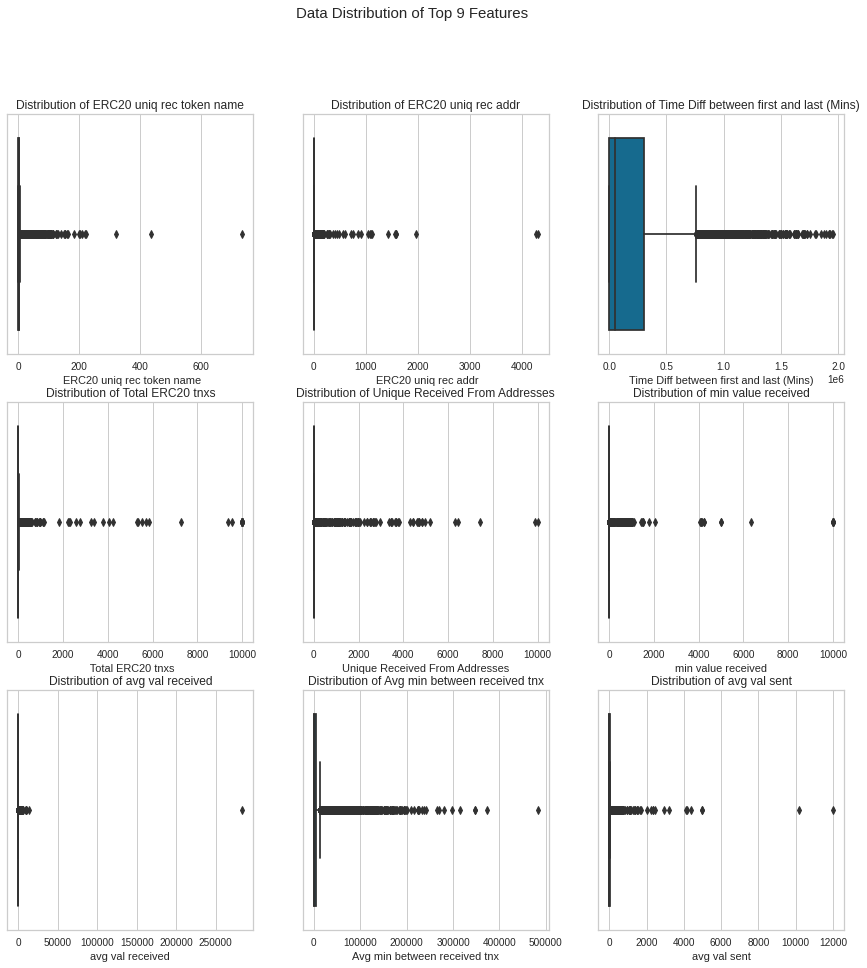

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))
fig.suptitle('Data Distribution of Top 9 Features',fontsize=15)

#ERC20 uniq rec token name
sns.boxplot(ax=axes[0,0], data=data, x= ' ERC20 uniq rec token name')
axes[0,0].set_title('Distribution of ERC20 uniq rec token name')

#ERC20 uniq rec addr
sns.boxplot(ax=axes[0,1], data=data, x= ' ERC20 uniq rec addr')
axes[0,1].set_title('Distribution of ERC20 uniq rec addr')

#Time Diff between first and last (Mins)
sns.boxplot(ax=axes[0,2], data=data, x= 'Time Diff between first and last (Mins)')
axes[0,2].set_title('Distribution of Time Diff between first and last (Mins)')

#Total ERC20 tnxs
sns.boxplot(ax=axes[1,0], data=data, x= ' Total ERC20 tnxs')
axes[1,0].set_title('Distribution of Total ERC20 tnxs')

#Unique Received From Addresses
sns.boxplot(ax=axes[1,1], data=data, x= 'Unique Received From Addresses')
axes[1,1].set_title('Distribution of Unique Received From Addresses')

#min val received
sns.boxplot(ax=axes[1,2], data=data, x= 'min value received')
axes[1,2].set_title('Distribution of min value received')

#avg val received
sns.boxplot(ax=axes[2,0], data=data, x= 'avg val received')
axes[2,0].set_title('Distribution of avg val received')

#Avg min between received tnx
sns.boxplot(ax=axes[2,1], data=data, x= 'Avg min between received tnx')
axes[2,1].set_title('Distribution of Avg min between received tnx')

#avg val sent
sns.boxplot(ax=axes[2,2], data=data, x= 'avg val sent')
axes[2,2].set_title('Distribution of avg val sent')

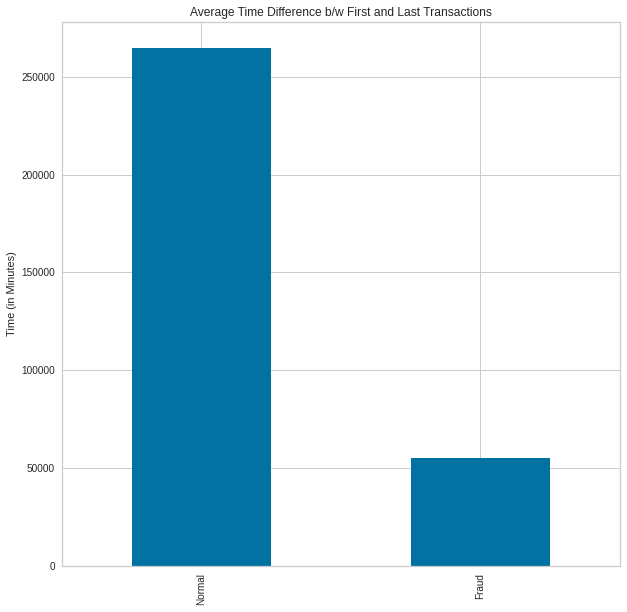

In [ ]:
plotdata = pd.DataFrame(index=['Normal','Fraud'], data=[non_fraud_records['Time Diff between first and last (Mins)'].mean(),imputed_fraud_data['Time Diff between first and last (Mins)'].mean()])
plotdata.plot(kind='bar',figsize=(10,10),title='Average Time Difference b/w First and Last Transactions',legend=False, ylabel='Time (in Minutes)')
plt.show()

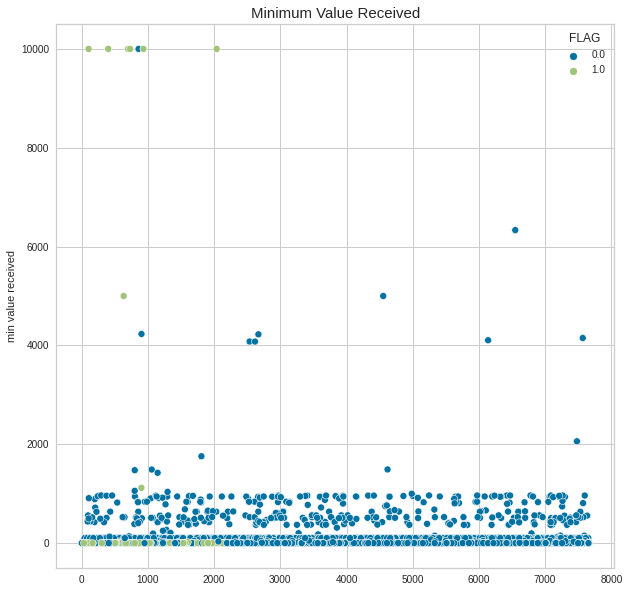

In [ ]:
plt.figure(figsize=(10,10))
plt.title('Minimum Value Received',fontsize=15)
sns.scatterplot(x=data.index,y=data['min value received'],hue=y)
plt.show()

# <h2><b>Splitting Data</b></h2>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data,y,test_size = 0.2, random_state =42)

<h2><b>Transforming Data<b></h2>

In [ ]:
scaler = PowerTransformer()

transformed_train_data = scaler.fit_transform(X_train)
transformed_test_data = scaler.transform(X_test)

transformed_train_data = pd.DataFrame(transformed_train_data,columns=X_train.columns)
transformed_test_data = pd.DataFrame(transformed_test_data,columns = X_test.columns)

Text(0.5, 1.0, 'Distribution of avg val sent')

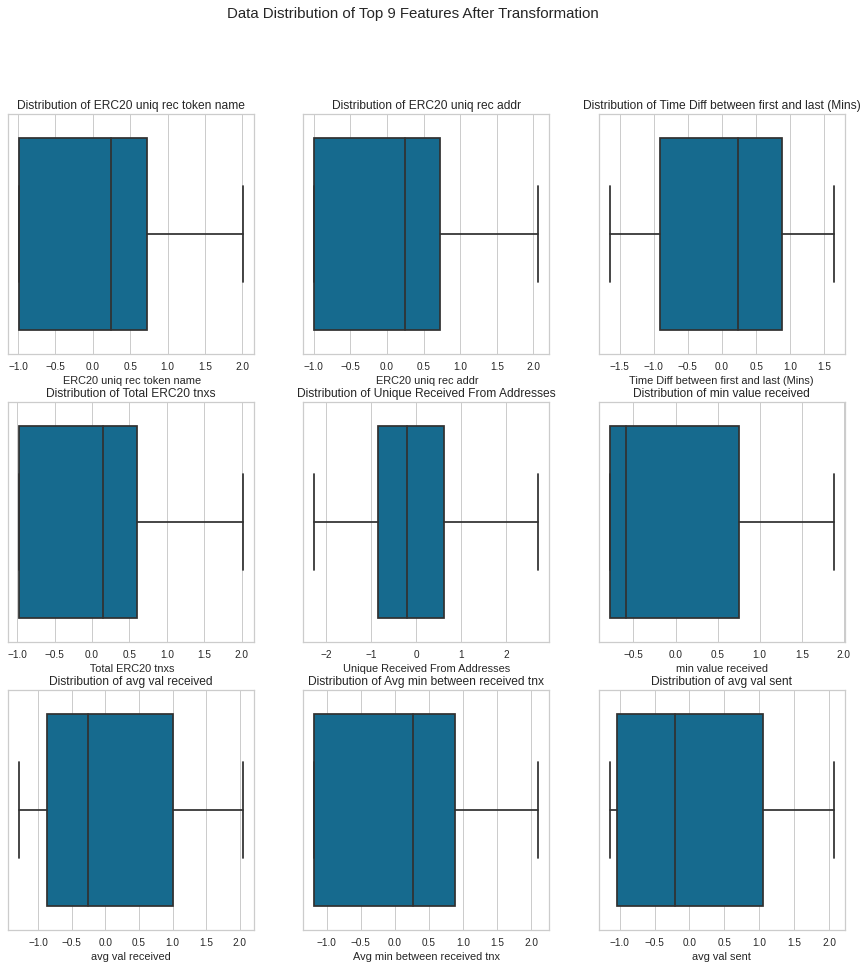

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15,15))
fig.suptitle('Data Distribution of Top 9 Features After Transformation',fontsize=15)

#ERC20 uniq rec token name
sns.boxplot(ax=axes[0,0], data=transformed_train_data, x= ' ERC20 uniq rec token name')
axes[0,0].set_title('Distribution of ERC20 uniq rec token name')

#ERC20 uniq rec addr
sns.boxplot(ax=axes[0,1], data=transformed_train_data, x= ' ERC20 uniq rec addr')
axes[0,1].set_title('Distribution of ERC20 uniq rec addr')

#Time Diff between first and last (Mins)
sns.boxplot(ax=axes[0,2], data=transformed_train_data, x= 'Time Diff between first and last (Mins)')
axes[0,2].set_title('Distribution of Time Diff between first and last (Mins)')

#Total ERC20 tnxs
sns.boxplot(ax=axes[1,0], data=transformed_train_data, x= ' Total ERC20 tnxs')
axes[1,0].set_title('Distribution of Total ERC20 tnxs')

#Unique Received From Addresses
sns.boxplot(ax=axes[1,1], data=transformed_train_data, x= 'Unique Received From Addresses')
axes[1,1].set_title('Distribution of Unique Received From Addresses')

#min val received
sns.boxplot(ax=axes[1,2], data=transformed_train_data, x= 'min value received')
axes[1,2].set_title('Distribution of min value received')

#avg val received
sns.boxplot(ax=axes[2,0], data=transformed_train_data, x= 'avg val received')
axes[2,0].set_title('Distribution of avg val received')

#Avg min between received tnx
sns.boxplot(ax=axes[2,1], data=transformed_train_data, x= 'Avg min between received tnx')
axes[2,1].set_title('Distribution of Avg min between received tnx')

#avg val sent
sns.boxplot(ax=axes[2,2], data=transformed_train_data, x= 'avg val sent')
axes[2,2].set_title('Distribution of avg val sent')

# <h2><b>Oversampling Using SMOTE</b></h2>

In [ ]:
oversample = SMOTE()
oversampled_data,y_train = oversample.fit_resample(transformed_train_data,y_train)

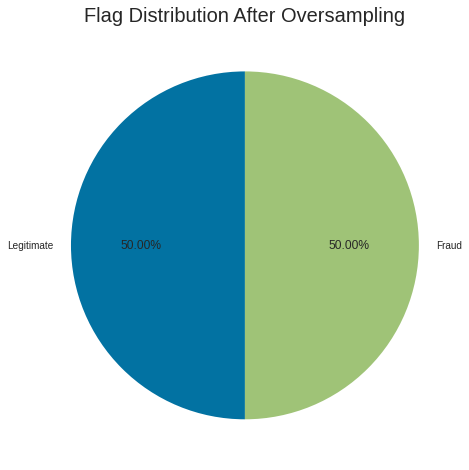

In [ ]:
plt.figure(figsize = (8,8))
plt.pie(y_train.value_counts(),labels = ['Legitimate','Fraud'], startangle = 90, autopct = '%1.2f%%')
plt.title('Flag Distribution After Oversampling',fontsize = 20)
plt.show()

# <h2><b>Building Classifier Models</b></h2>

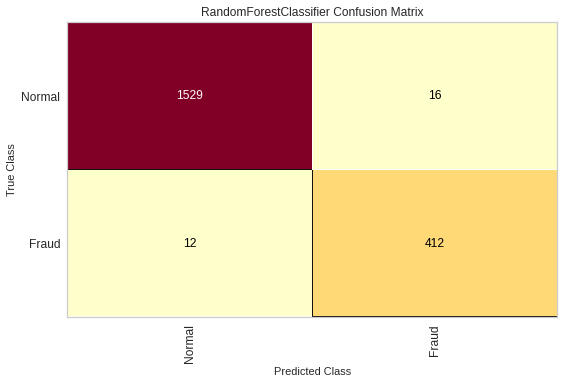

In [ ]:
model = RandomForestClassifier(criterion='entropy',n_estimators=200)
rf_cm = ConfusionMatrix(model,classes=['Normal','Fraud'])
rf_cm.fit(oversampled_data,y_train)
rf_cm.score(transformed_test_data,y_test)
rf_cm.show()

In [ ]:
pred = model.predict(transformed_test_data)
precision_score(pred,y_test)

0.9716981132075472

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


<Figure size 720x720 with 0 Axes>

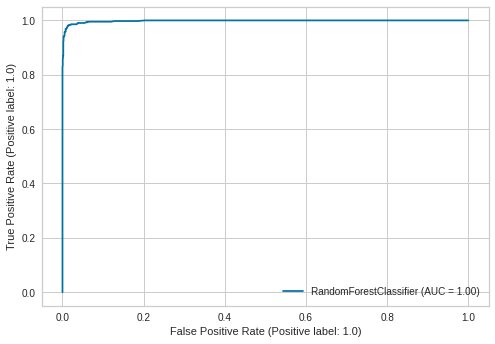

In [ ]:
plt.figure(figsize=(10,10))
plot_roc_curve(model,transformed_test_data,y_test)
plt.show()

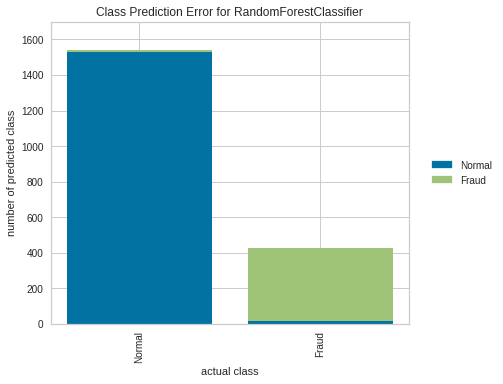

In [ ]:
viz = ClassPredictionError(RandomForestClassifier(criterion='entropy'),classes=['Normal','Fraud'])
viz.fit(oversampled_data,y_train)
viz.score(transformed_test_data,y_test)
viz.show()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


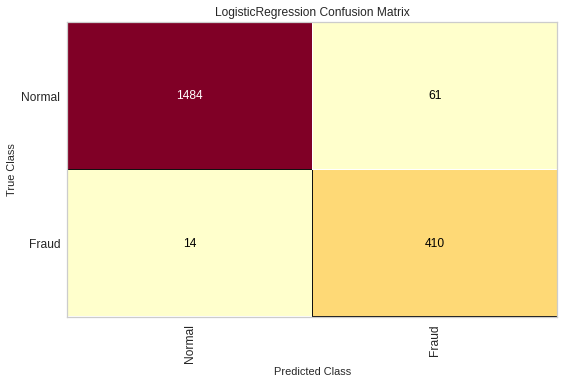

In [ ]:
model = LogisticRegression()
lr_cm = ConfusionMatrix(model,classes=['Normal','Fraud'])
lr_cm.fit(oversampled_data,y_train)
lr_cm.score(transformed_test_data,y_test)
lr_cm.show()

In [ ]:
pred = model.predict(transformed_test_data)
precision_score(pred,y_test)

0.9669811320754716

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


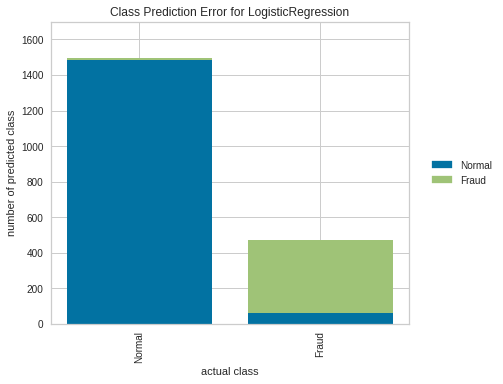

In [ ]:
viz = ClassPredictionError(LogisticRegression(),classes=['Normal','Fraud'])
viz.fit(oversampled_data,y_train)
viz.score(transformed_test_data,y_test)
viz.show()

In [ ]:
model = xgb.XGBClassifier(random_state=42)
model.fit(oversampled_data,y_train)
pred = model.predict(transformed_test_data)
confusion_matrix(pred,y_test)

array([[1520,    9],
       [  25,  415]])

In [ ]:
precision_score(y_test,pred)

0.9431818181818182